# General probabilistic 1D linear regression experiments

When data is generated from a GP, it is unsurprising that a GP performs well and this also applies to other models. However, when the true data generating distribution is more unusual, how does directly targeting the predictive distribution compare to Bayesian approaches?

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import beta as Beta
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import gaussian_filter1d
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from scipy.integrate import quad
from scipy.optimize import bisect
import math
# import gpytorch
# from torch.utils.data import DataLoader, TensorDataset

In [2]:
# MPS (apple silicon support)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
colors = ["royalblue", "red", "orange"]

## Gaussian with heteroscedastic variance

In [4]:
sigma = np.vectorize(lambda x : 0.05*(np.exp((1-2*x**2)*np.sin(7*x)))**1.2)
mu = np.vectorize(lambda x : -0.5 * x * np.sin(10*x))

n = 1400
x = np.random.uniform(0, 1, n)
x = x[(x < 0.4) | (x > 0.5)]  # missing data between 0.4 and 0.5
x = x[(x < 0.85)]  # missing data above 0.85
y = np.random.normal(mu(x), sigma(x))

In [5]:
x_vals = np.linspace(0, 1, 200)
mu_vals = mu(x_vals)
sigma_vals = sigma(x_vals)

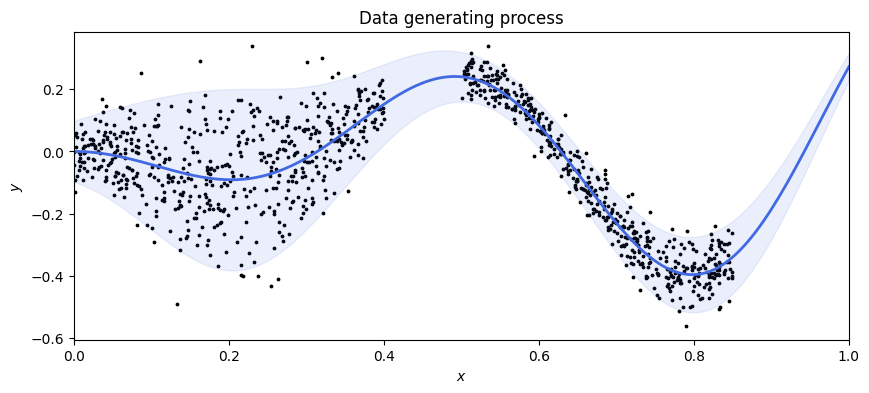

In [6]:
norm_crit = norm.ppf(0.975)

plt.figure(figsize=(10,4))
plt.scatter(x, y, s=3, color="black")
plt.fill_between(x_vals, mu_vals-norm_crit*sigma_vals, mu_vals+norm_crit*sigma_vals, color=colors[0], alpha=0.1)
plt.plot(x_vals, mu_vals, color=colors[0], linewidth=2)
plt.xlim(0,1)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.title("Data generating process")
plt.show()

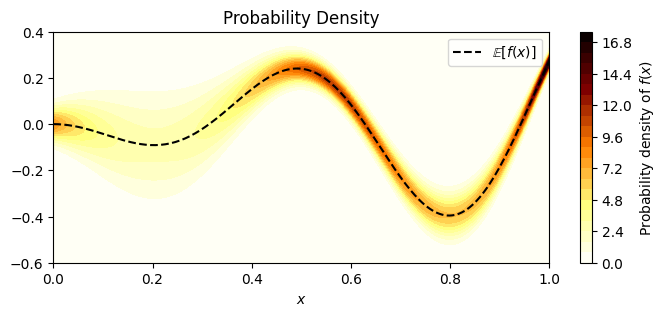

In [7]:
m = 1000
x_mesh, y_mesh = np.meshgrid(np.linspace(0, 1, m), np.linspace(-0.6, 0.4, m))
Z = norm(mu(x_mesh), sigma(x_mesh)).pdf(y_mesh)

plt.figure(figsize=(8,3))
plt.plot(x_vals, mu_vals, color="black", linestyle="--", label="$\mathbb{E}[f(x)]$")
contour = plt.contourf(x_mesh, y_mesh, Z, levels=25, cmap="afmhot_r") 
plt.colorbar(contour, label="Probability density of $f(x)$")
plt.xlim(0,1)
plt.title("Probability Density")
plt.legend()
plt.xlabel("$x$")
plt.show()

### Neural Moment Approximator

In [8]:
def t_log_pdf(y, loc, scale, df):
    return (
        torch.lgamma((df+1)/2) - torch.lgamma(df/2) - 0.5*torch.log(df * torch.pi) - torch.log(scale)
        - ((df+1)/2) * torch.log(1 + ((y - loc)**2) / (df * scale**2))
    ).to(dtype=torch.float32)

def norm_log_pdf(y, loc, scale):
    return (
        - 0.5*torch.log(torch.ones(y.shape[0], device=device)*2*torch.pi) -torch.log(scale)
        - (y - loc)**2 / (2 * scale**2)
    )#.to(dtype=torch.float32)

# def skew_t_log_pdf(y, loc, scale, ...):


In [9]:
class NormDistributionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Softplus(beta=1.0, threshold=20.0),
            nn.Linear(64, 128),
            nn.Softplus(beta=1.0, threshold=20.0),
            nn.Linear(128, 64),
            nn.Softplus(beta=1.0, threshold=20.0),
        )
        
        self.loc_head = nn.Linear(64, 1)
        self.scale_head = nn.Linear(64, 1)

    def forward(self, x):
        hidden = self.net(x)
        loc = self.loc_head(hidden)
        scale = torch.nn.functional.softplus(self.scale_head(hidden)) + 1e-6
        
        return (loc, scale)

In [10]:
x_train = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device=device)
y_train = torch.tensor(y, dtype=torch.float32).to(device=device)

model = NormDistributionModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [11]:
n_epochs=15_000
for epoch in range(n_epochs):
    optimizer.zero_grad()

    # forward pass
    loc, scale = model(x_train)
    log_pdf = norm_log_pdf(y_train, loc.squeeze(), scale.squeeze())
    loss = -torch.mean(log_pdf)

    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.6842
Epoch 1000, Loss: -0.8246
Epoch 2000, Loss: -1.1604
Epoch 3000, Loss: -1.2015
Epoch 4000, Loss: -1.1839
Epoch 5000, Loss: -1.2077
Epoch 6000, Loss: -1.2110
Epoch 7000, Loss: -1.2061
Epoch 8000, Loss: -1.2121
Epoch 9000, Loss: -1.2124
Epoch 10000, Loss: -1.2122
Epoch 11000, Loss: -1.2131
Epoch 12000, Loss: -1.2135
Epoch 13000, Loss: -1.1660
Epoch 14000, Loss: -1.2181


In [12]:
x_vals_tensor = torch.tensor(x_vals, dtype=torch.float32).unsqueeze(1).to(device)

model.eval()
with torch.no_grad():
    loc_vals, scale_vals = model(x_vals_tensor)

    loc_vals = loc_vals.cpu().squeeze()
    scale_vals = scale_vals.cpu().squeeze()

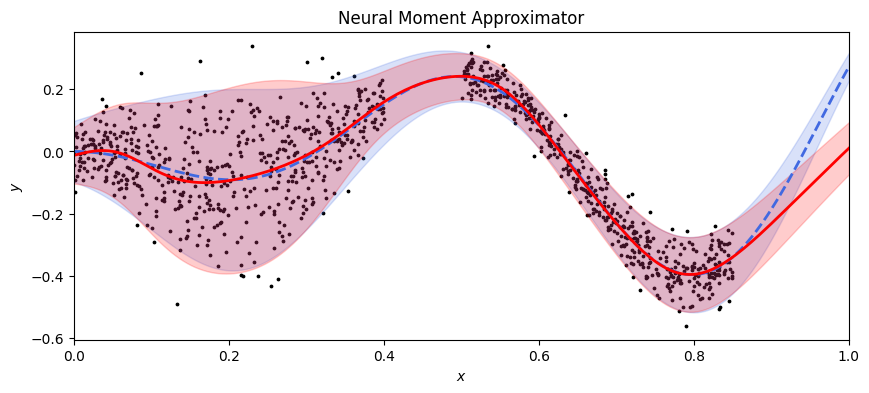

In [13]:
plt.figure(figsize=(10,4))
plt.scatter(x, y, s=3, color="black")
plt.fill_between(x_vals, mu_vals-norm_crit*sigma_vals, mu_vals+norm_crit*sigma_vals, color=colors[0], alpha=0.2)
plt.fill_between(x_vals, loc_vals-norm_crit*scale_vals, loc_vals+norm_crit*scale_vals, color=colors[1], alpha=0.2)
plt.plot(x_vals, mu_vals, color=colors[0], linewidth=2, linestyle="--")
plt.plot(x_vals, loc_vals, color=colors[1], linewidth=2)
plt.xlim(0,1)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.title("Neural Moment Approximator")
plt.show()


Training directly on the log probability density (with the right distribution - Gaussian in this case) leads to a very close fit to the true data generating distribution where data is observed (capturing aleotoric uncertainty well) but there is no regularisation to prevent wildly incorrect guesses on out of distribution areas (failing to capture epsitemic uncertainty).

#### Adding (extremely naive) variance regularisation

We add a fixed variance that is added for points away from the training manifold to act as regularisation and protect against overconfident out-of-distribution predictions. We can learn this with a validation set. Is it better to add a variance or add a seperate diffuse variable to the pdf such that there is still a spike where we expect data?


##### Distance from training set



In [14]:
smoothed_dist_vals = gaussian_filter1d(np.min(np.abs(x_vals[:, None] - x[None, :]), axis=1), sigma=4)

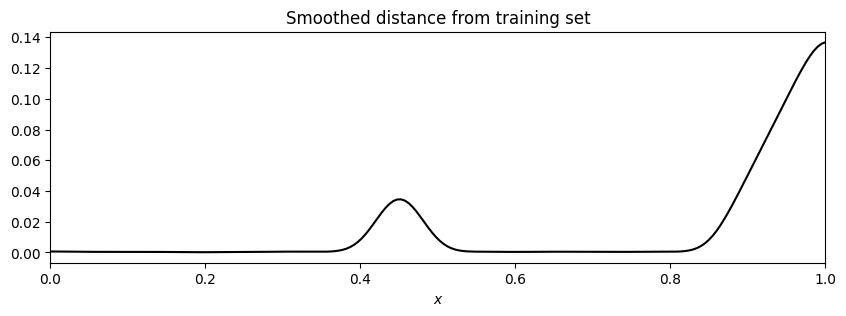

In [15]:
plt.figure(figsize=(10,3))
plt.plot(x_vals, smoothed_dist_vals, color="black", linewidth=1.5)
plt.xlim(0,1)
plt.xlabel("$x$")
plt.title("Smoothed distance from training set")
plt.show()

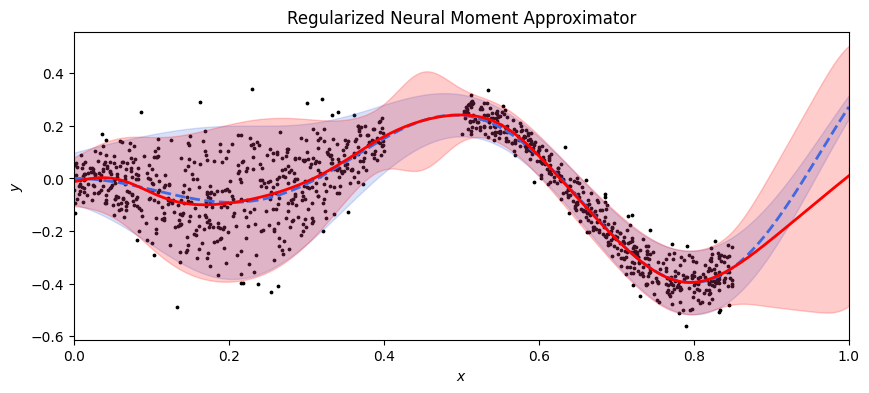

In [16]:
k=3

plt.figure(figsize=(10,4))
plt.scatter(x, y, s=3, color="black")
plt.fill_between(x_vals, mu_vals-norm_crit*sigma_vals, mu_vals+norm_crit*sigma_vals, color=colors[0], alpha=0.2)
plt.fill_between(x_vals, loc_vals-norm_crit*scale_vals-k*torch.from_numpy(smoothed_dist_vals), loc_vals+norm_crit*scale_vals+k*torch.from_numpy(smoothed_dist_vals), color=colors[1], alpha=0.2)
plt.plot(x_vals, mu_vals, color=colors[0], linewidth=2, linestyle="--")
plt.plot(x_vals, loc_vals, color=colors[1], linewidth=2)
plt.xlim(0,1)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.title("Regularized Neural Moment Approximator")
plt.show()

This is not the best way to do this, and likely we should use an (ideally ood) validation set to learn how much regularization is necessary, and the regularization should be guided by some "prior" on function space. Additionally, naively using distance from training manifold doesn't take into account the fact that one point close in the training manifold is not equal to many points.

In [17]:
length_scale = 0.12
pairwise_dists = np.abs(x[:, np.newaxis] - x_vals)
kernel_vals = np.exp(-pairwise_dists**2 / (2 * length_scale**2))
dist_vals = kernel_vals.sum(axis=0)

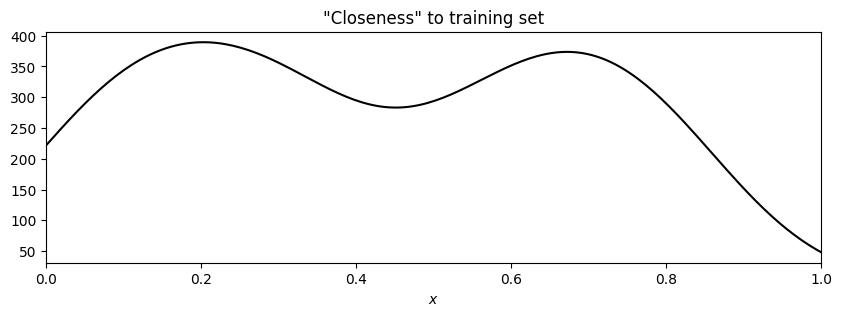

In [18]:
plt.figure(figsize=(10,3))
plt.plot(x_vals, dist_vals, color="black", linewidth=1.5)
plt.xlim(0,1)
plt.xlabel("$x$")
plt.title("\"Closeness\" to training set")
plt.show()

### GP model

In [19]:
X_train = x.reshape(-1, 1)
y_train = y

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=0.1, length_scale_bounds=(1e-2, 1.0)) + WhiteKernel(noise_level=1)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)
gp.fit(X_train, y_train)

/Users/jamie/dev/statml/martingale-predictive/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=0.1,
                         kernel=1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

In [20]:
X_vals = x_vals.reshape(-1, 1)
y_pred, sigma_pred = gp.predict(X_vals, return_std=True)

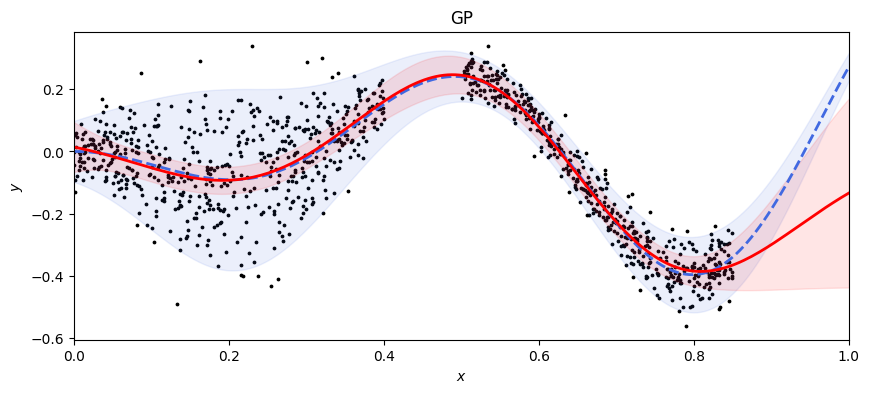

In [21]:
plt.figure(figsize=(10,4))
plt.scatter(x, y, s=3, color="black")
plt.fill_between(x_vals, mu_vals-norm_crit*sigma_vals, mu_vals+norm_crit*sigma_vals, color=colors[0], alpha=0.1)
plt.plot(x_vals, mu_vals, color=colors[0], linewidth=2, linestyle="--")
plt.fill_between(x_vals, y_pred-norm_crit*sigma_pred, y_pred+norm_crit*sigma_pred, color=colors[1], alpha=0.1)
plt.plot(x_vals, y_pred, color=colors[1], linewidth=2)
plt.xlim(0,1)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.title("GP")
plt.show()

Although this GP's hyperparameters aren't tuned, it still seems clear that GPs are not well suited to this kind of non-stationarity.

### NMA with different data missing

In [22]:
n = 1000
x = np.random.uniform(0, 1, n)
x = x[(x < 0.55) | (x > 0.7)]  # missing data between 0.55 and 0.7
x = x[(x < 0.9)]  # missing data above 0.9
y = np.random.normal(mu(x), sigma(x))

In [25]:
x_train = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device=device)
y_train = torch.tensor(y, dtype=torch.float32).to(device=device)

model = NormDistributionModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [26]:
n_epochs=15_000
for epoch in range(n_epochs):
    optimizer.zero_grad()

    # forward pass
    loc, scale = model(x_train)
    log_pdf = norm_log_pdf(y_train, loc.squeeze(), scale.squeeze())
    loss = -torch.mean(log_pdf)

    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 1.2703
Epoch 1000, Loss: -1.2522
Epoch 2000, Loss: -1.2544
Epoch 3000, Loss: -1.2549
Epoch 4000, Loss: -1.2213
Epoch 5000, Loss: -1.2477
Epoch 6000, Loss: -1.1883
Epoch 7000, Loss: -1.2499
Epoch 8000, Loss: -1.2464
Epoch 9000, Loss: -1.2517
Epoch 10000, Loss: -1.2504
Epoch 11000, Loss: -1.2297
Epoch 12000, Loss: -1.2289
Epoch 13000, Loss: -1.2460
Epoch 14000, Loss: -1.2101


In [27]:
x_vals_tensor = torch.tensor(x_vals, dtype=torch.float32).unsqueeze(1).to(device)

model.eval()
with torch.no_grad():
    loc_vals, scale_vals = model(x_vals_tensor)

    loc_vals = loc_vals.cpu().squeeze()
    scale_vals = scale_vals.cpu().squeeze()

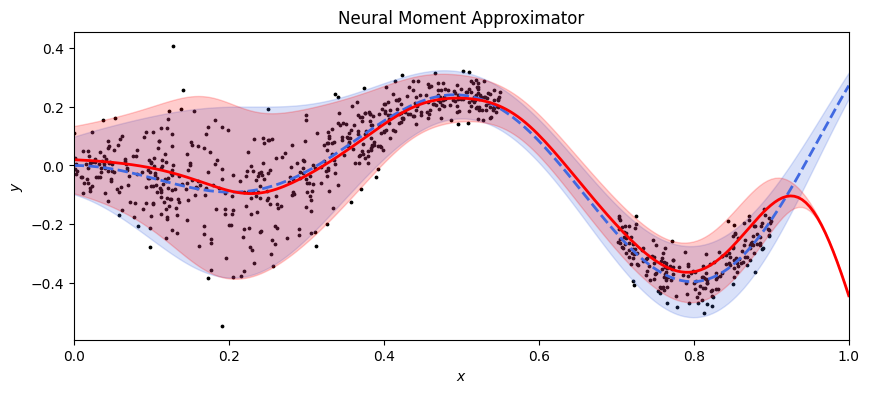

In [28]:
plt.figure(figsize=(10,4))
plt.scatter(x, y, s=3, color="black")
plt.fill_between(x_vals, mu_vals-norm_crit*sigma_vals, mu_vals+norm_crit*sigma_vals, color=colors[0], alpha=0.2)
plt.fill_between(x_vals, loc_vals-norm_crit*scale_vals, loc_vals+norm_crit*scale_vals, color=colors[1], alpha=0.2)
plt.plot(x_vals, mu_vals, color=colors[0], linewidth=2, linestyle="--")
plt.plot(x_vals, loc_vals, color=colors[1], linewidth=2)
plt.xlim(0,1)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.title("Neural Moment Approximator")
plt.show()

Can perform terribly out of distribution still...

## Skewed t-distribution with heteroscedastic variance

In [ ]:
# def inverse_cdf(u, pdf_func, lower_bound=-10, upper_bound=10):
#     target_cdf = lambda x: quad(pdf_func, lower_bound, x)[0] - u
#     return bisect(target_cdf, lower_bound, upper_bound)

# def sample_pdf(n_samples, pdf_func, lower_bound=-10, upper_bound=10):
#     samples = []
#     for _ in range(n_samples):
#         u = np.random.uniform(0, 1)
#         sample = inverse_cdf(u, pdf_func, lower_bound, upper_bound)
#         samples.append(sample)
#     return np.array(samples)

In [ ]:
# sgn = lambda x: math.copysign(1, x)

# def gst_pdf(x, mu_, sigma_, lambda_, p_, q_):
#     v = q_**(-1/p_) / np.sqrt( (1+3*lambda_**2) * Beta(3/p_, q_-2/p_) / Beta(1/p_, q_) - 4*lambda_**2 * Beta(2/p_, 1 - 1/p_)**2 / Beta(1/p_, q_)**2 )
#     m = lambda_*v*sigma_ * (2*q_**(1/p_) * Beta(2/p_, q_ - 1/p_)) / Beta(1/p_, q_)
#     A = 2 * v * sigma_ * (q_**(1/p_)) * Beta(1/p_, q_)
#     B = 1 + np.abs(x - mu_ + m)**p_ / ( q_*(v*sigma_)**p_ * (1+lambda_*sgn(x - mu_ + m))**p_ )
#     return p_ / (A * B**(1/p_ + q_))

In [ ]:
# def pdf(mu_, sigma_, lambda_, p_, q_):
#     return lambda x: gst_pdf(x, mu_, sigma_, lambda_, p_, q_)

In [ ]:
# example_pdf = pdf(0, 1, 1, 2, 6)

# y_temp = np.linspace(-1, 1, 200)
# np.array([example_pdf(y) for y in y_temp])

# z_temp = y_temp

# plt.figure(figsize=(10,4))
# plt.plot(y_temp, z_temp, color="black", linewidth=1.5)
# plt.xlabel("$y$")
# plt.show()

# n_samples = 1000
# samples = sample_pdf(n_samples, gst_pdf, lower_bound=-10, upper_bound=10)

# plt.hist(samples, bins=50, density=True)
# plt.xlabel("x")
# plt.ylabel("Density")
# plt.show()

In [ ]:
# sigma = np.vectorize(lambda x : 0.05*(np.exp((1-2*x**2)*np.sin(7*x)))**1.2)
# mu = np.vectorize(lambda x : -0.5 * x * np.sin(10*x))

# n = 1000
# x = np.random.uniform(0, 1, n)
# x = x[(x < 0.4) | (x > 0.5)]  # missing data between 0.4 and 0.5
# x = x[(x < 0.85)]  # missing data above 0.85
# y = np.random.normal(mu(x), sigma(x))

In [ ]:
# x_vals = np.linspace(0, 1, 200)
# mu_vals = mu(x_vals)
# sigma_vals = sigma(x_vals)

In [ ]:
# norm_crit = norm.ppf(0.975)

# plt.figure(figsize=(10,4))
# plt.scatter(x, y, s=3, color="black")
# plt.fill_between(x_vals, mu_vals-norm_crit*sigma_vals, mu_vals+norm_crit*sigma_vals, color=colors[0], alpha=0.1)
# plt.plot(x_vals, mu_vals, color=colors[0], linewidth=2)
# plt.xlim(0,1)
# plt.xlabel("$x$"); plt.ylabel("$y$")
# plt.title("Data generating process")
# plt.show()